CNN - Malaria Dataset was obtained from https://ceb.nlm.nih.gov/repositories/malaria-datasets/. In this project, we will distinguish between parasitic and nonparasitic cell from a thin blood smear slide images of semgmented cells. The folder contains about 27,560 samples, where it's split with 90% training set and 10% test set. Many of images comes with different size and shapes, but we can fix them with transformations and push it into tensors. I will be using PyTorch and Tensorflow for this project.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import copy
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080 Ti'

In [3]:
writer = SummaryWriter('Tensorboard')

In [4]:
data_dir = 'SL_CNN/data/cell_images'
train_path = data_dir + '/train'
test_path = data_dir + '/test'

In [5]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [6]:
# Pytorch's default for normalizing images, based on Imagenet.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

For this project, I'm only going to use a few transformations

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [8]:
data_dir = 'SL_CNN/data/cell_images'
sets = ['train','test']
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x]) for x in ['train','test']}
dataloader = {x:torch.utils.data.DataLoader(image_datasets[x],
                  batch_size=16, shuffle=True, num_workers=0) for x in ['train','test']}
data_size = {x:len(image_datasets[x]) for x in ['train','test']}
classes = image_datasets['train'].classes

In [9]:
print(classes)

['parasitized', 'uninfected']


Create an image visualization function

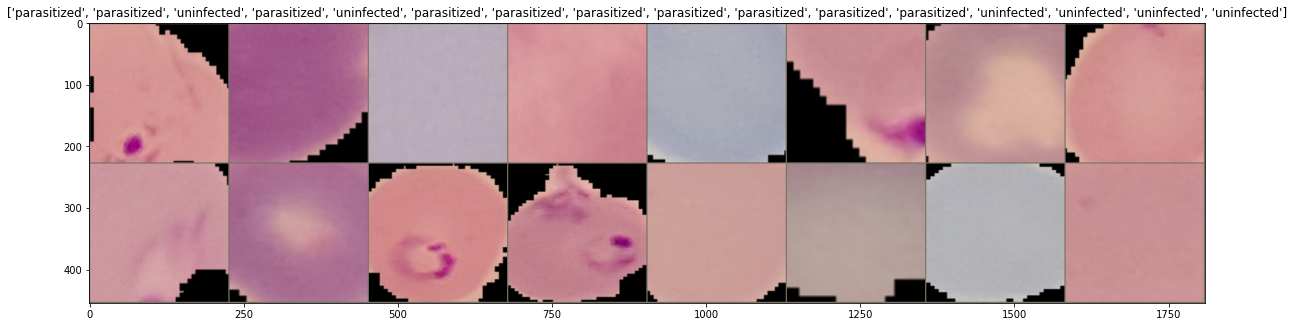

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,50))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes_ = next(iter(dataloader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes[x] for x in classes_])

In [11]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

c:\Users\antho\anaconda3\envs\mytfenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


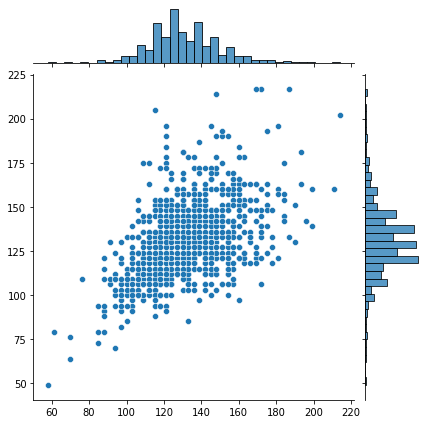

In [12]:
sns.jointplot(dim1,dim2)

We see that majority of the datapoints are clustered around the dimensions (140,140), which is great. The distribution of the sample's dimension looks close to normal, which is good to note when dealing how to transform the images. We can transform by rotation, shifting rescaling, flipping, filling, etc. There are outliers noted especially on the bottom left, with small dimension as low as (60,50).

We're going to create a function to train the model with my RTX 3080 TI

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    begin_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc=0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Epochs per training AND testing phases
        for phase in ['train','test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss=0
            running_correct=0
            
            # Iterate
            for inputs, labels in dataloader[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                #forward
                # track history only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    #backward pass and optimize only in training
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                # Statistic
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds==labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss/data_size[phase]
            epoch_acc = running_correct.double()/data_size[phase]
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            writer.add_scalar('training_loss', epoch_loss, epoch*len(dataloader['train'].dataset))
            writer.add_scalar('model_accuracy', epoch_acc, epoch*len(dataloader['train'].dataset))
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    end_time = time.time()
    time_elapsed = end_time-begin_time
    print('Training completion time: {:.0f} minutes {:.0f} seconds'.format(time_elapsed//60, time_elapsed%60))
    print('Best Test Accuracy: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model


One of the CNN Architecture I'll be using ResNet18, as it helps keep a low error rate in deep learning in my experience.

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))

#upload to my GPU
model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Optimization... learning rate is set to 0.001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.8)
# Decrease learning rate by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)



c:\Users\antho\anaconda3\envs\mytfenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\anaconda3\envs\mytfenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3401 Accuracy: 0.8511
test Loss: 0.1345 Accuracy: 0.9492

Epoch 1/9
----------
train Loss: 0.2962 Accuracy: 0.8725
test Loss: 0.1297 Accuracy: 0.9562

Epoch 2/9
----------
train Loss: 0.2786 Accuracy: 0.8813
test Loss: 0.1229 Accuracy: 0.9558

Epoch 3/9
----------
train Loss: 0.2715 Accuracy: 0.8835
test Loss: 0.1386 Accuracy: 0.9562

Epoch 4/9
----------
train Loss: 0.2663 Accuracy: 0.8882
test Loss: 0.1129 Accuracy: 0.9604

Epoch 5/9
----------
train Loss: 0.2554 Accuracy: 0.8924
test Loss: 0.1104 Accuracy: 0.9608

Epoch 6/9
----------
train Loss: 0.2539 Accuracy: 0.8931
test Loss: 0.1106 Accuracy: 0.9631

Epoch 7/9
----------
train Loss: 0.2512 Accuracy: 0.8934
test Loss: 0.1125 Accuracy: 0.9604

Epoch 8/9
----------
train Loss: 0.2491 Accuracy: 0.8937
test Loss: 0.1119 Accuracy: 0.9615

Epoch 9/9
----------
train Loss: 0.2441 Accuracy: 0.8970
test Loss: 0.1040 Accuracy: 0.9631

Training completion time: 14 minutes 20 seconds
Best Test Accuracy: 0.

I only did 10 epochs because I'm dealing with a large data set. I would impliment a stop loss, but I don't have the time to wait for the model to converge at a stopping point, as every epoch takes around 2-3 minutes intervals. During the training process, I can see that the training loss is decreasing at a slow rate and the training accuracy is slowly rising up. 

In [16]:
model_path = 'IBM_TransferLearning.pth'
torch.save(model_ft.state_dict(), model_path)

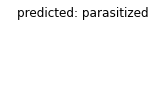

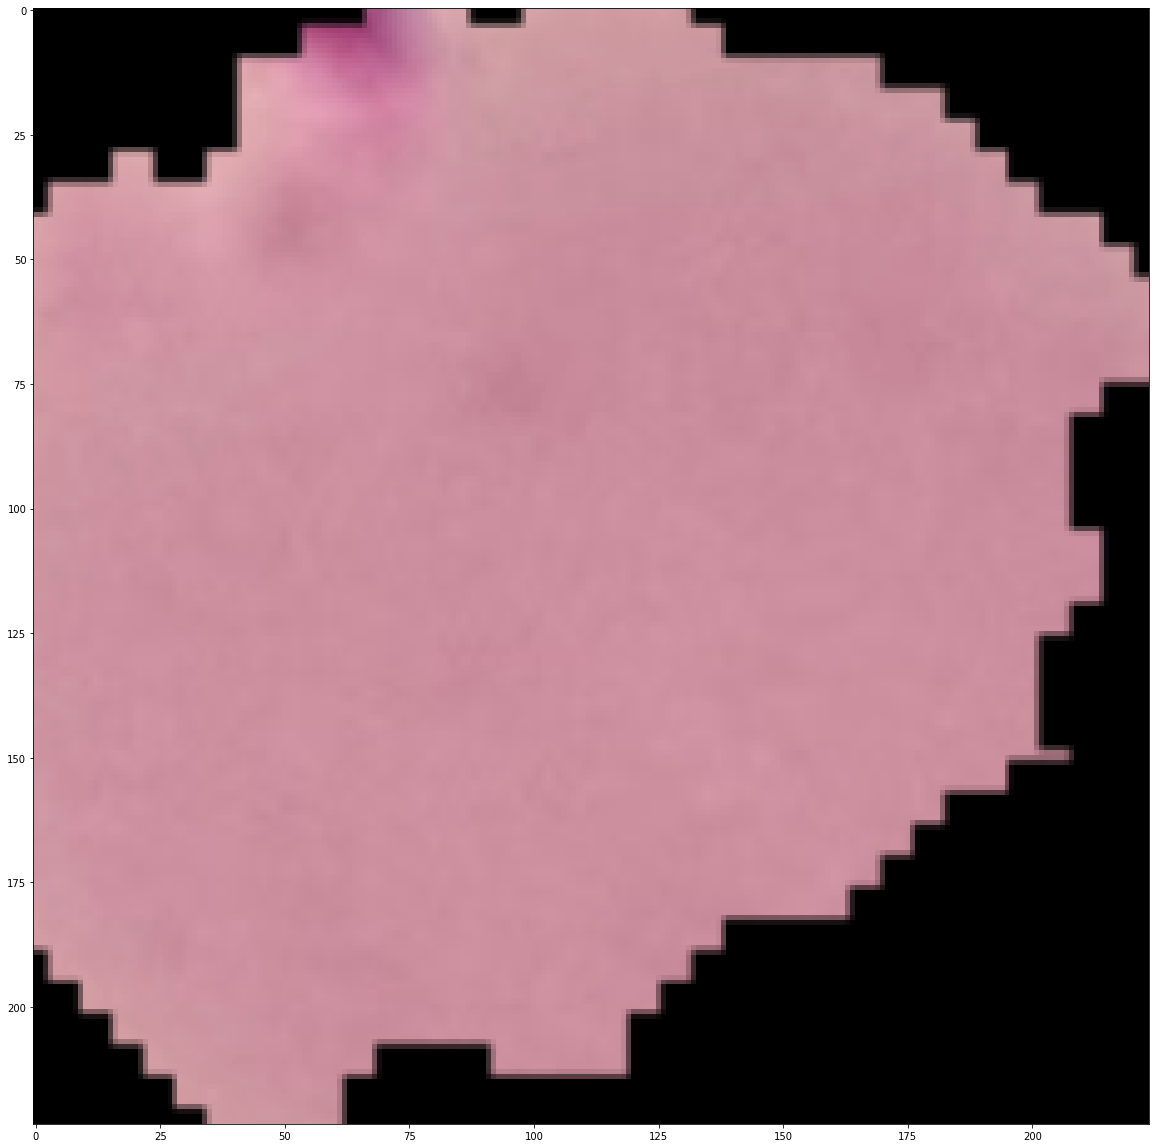

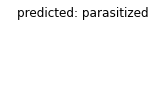

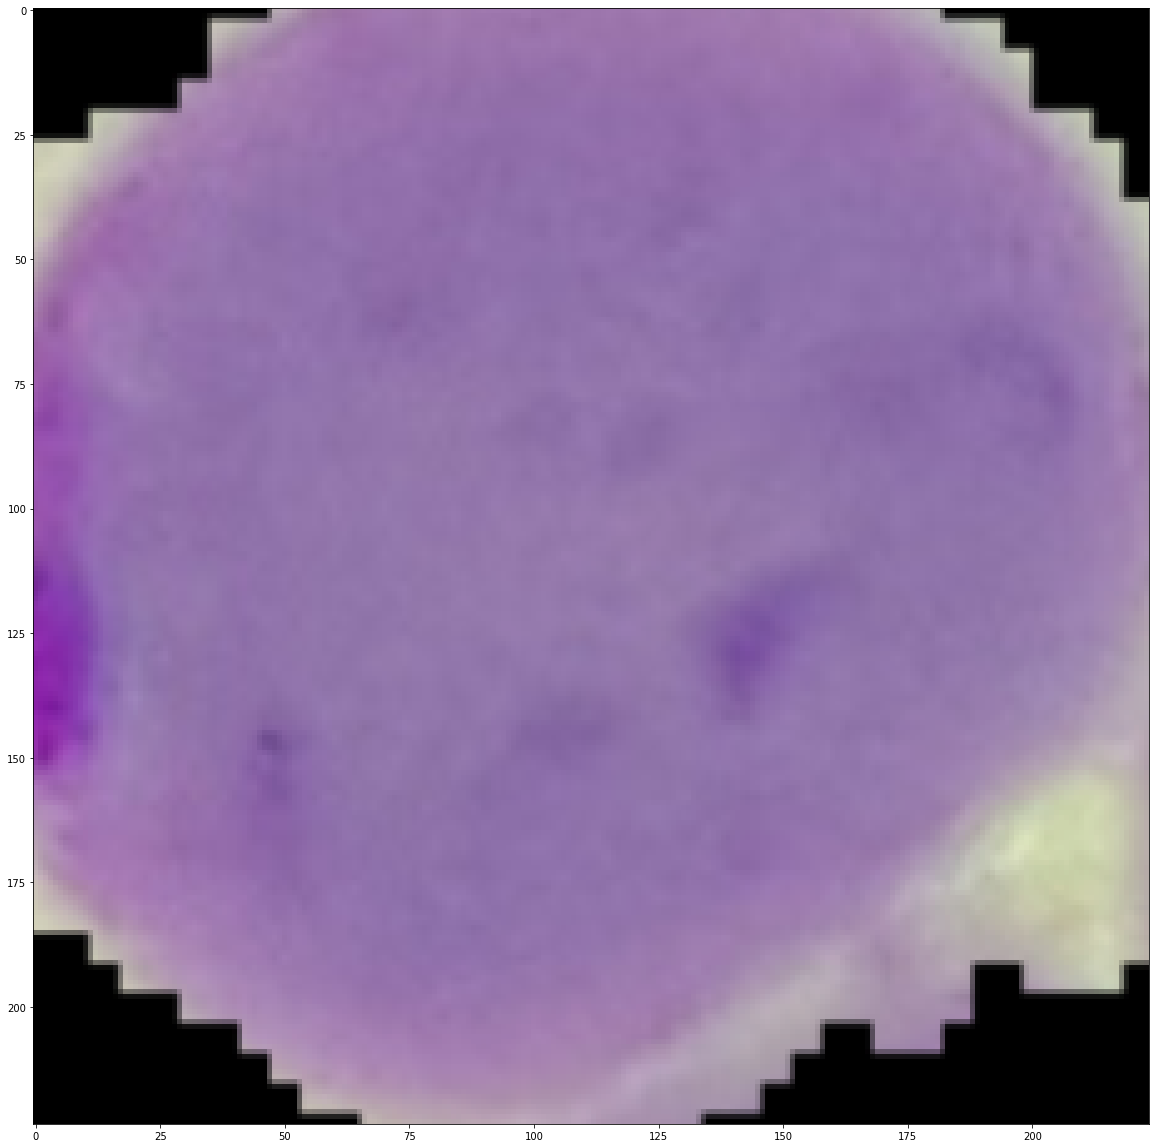

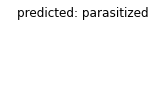

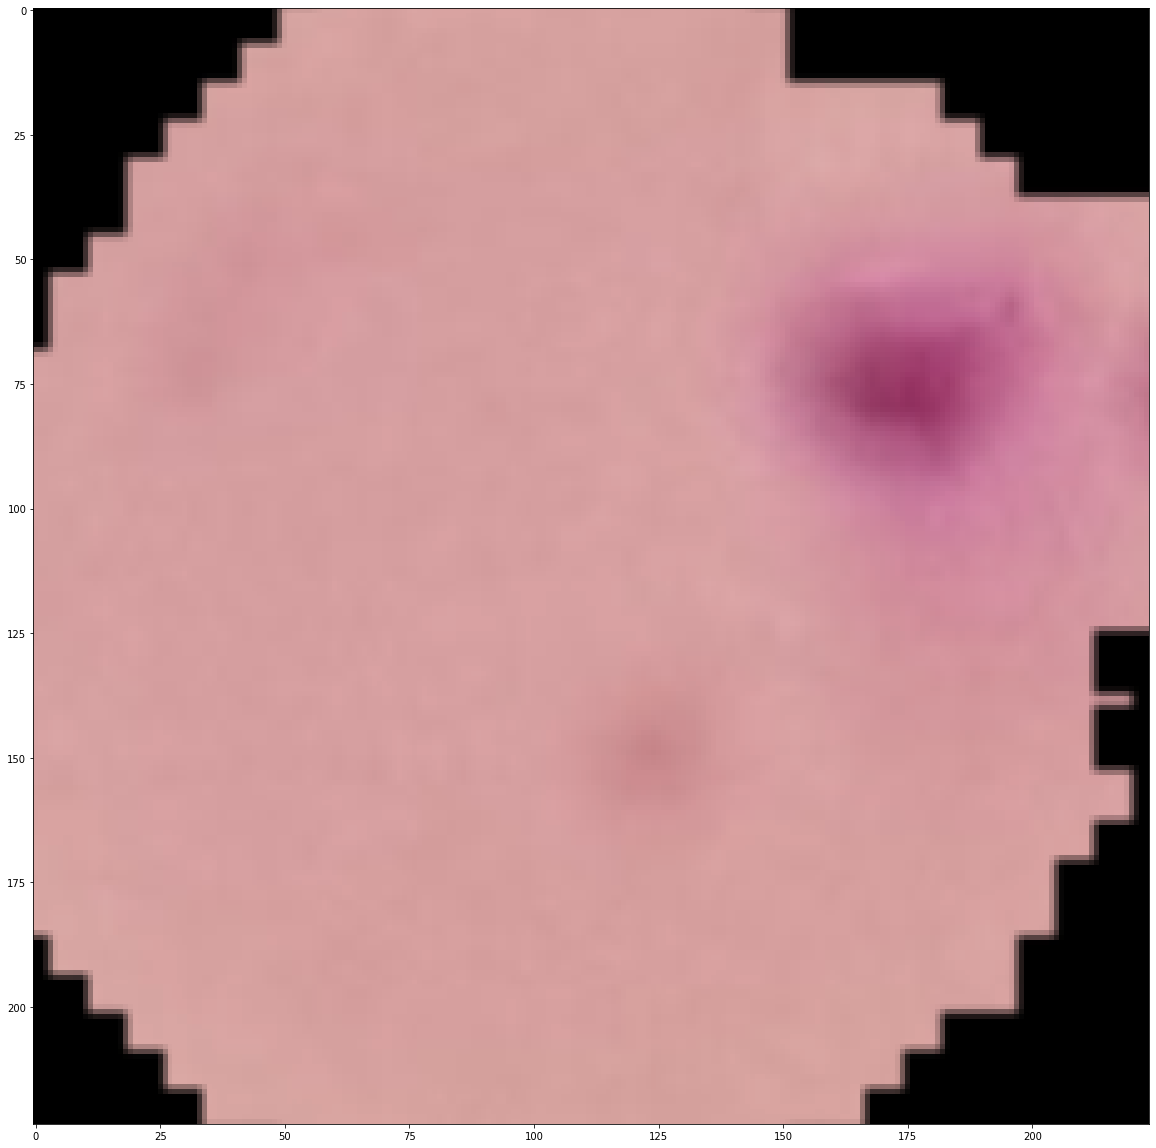

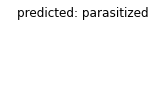

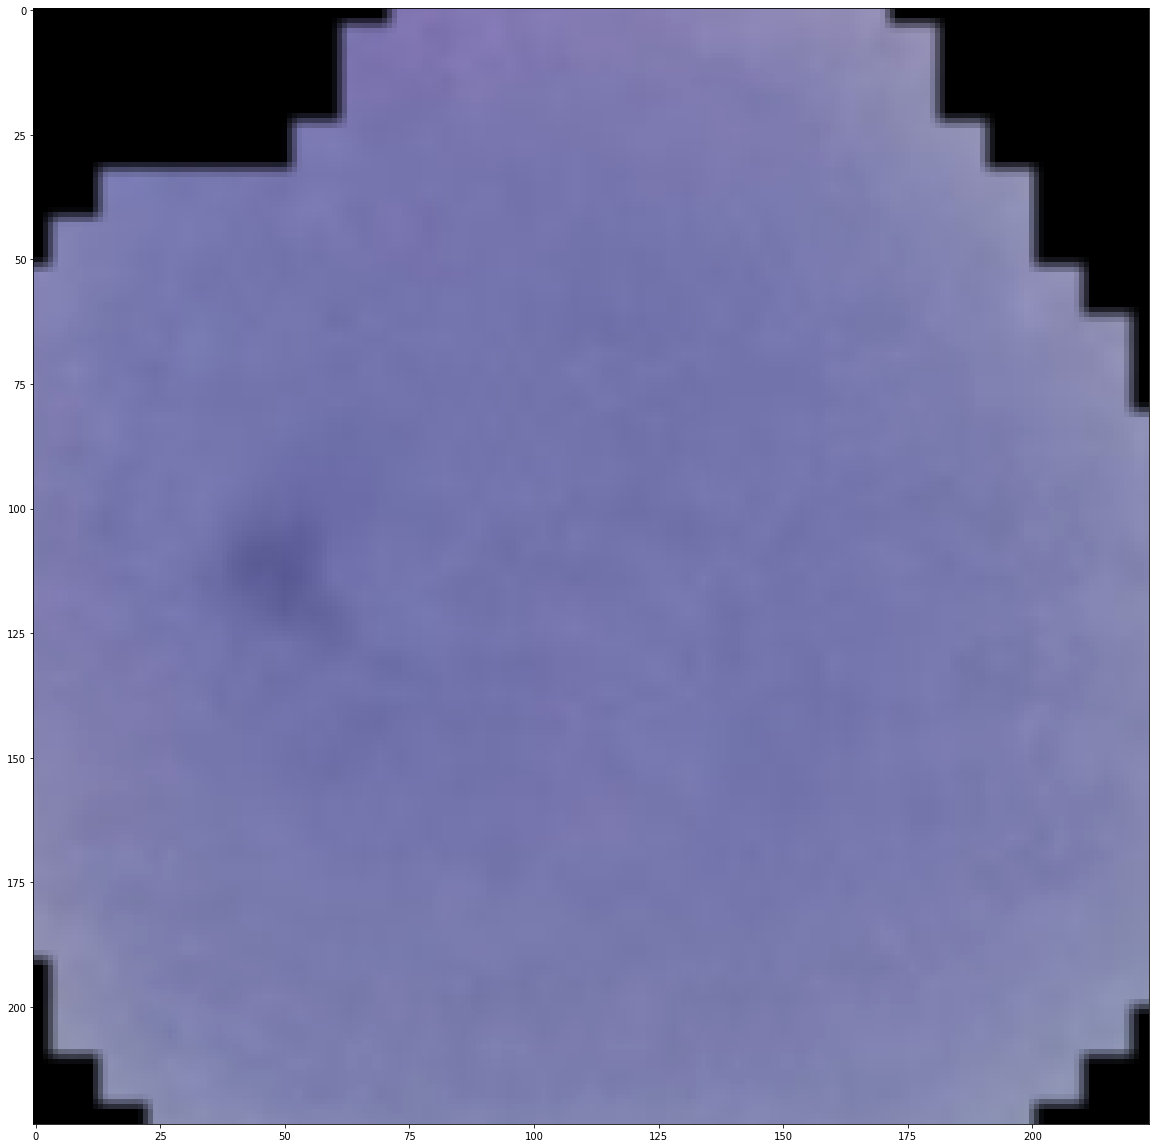

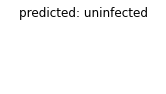

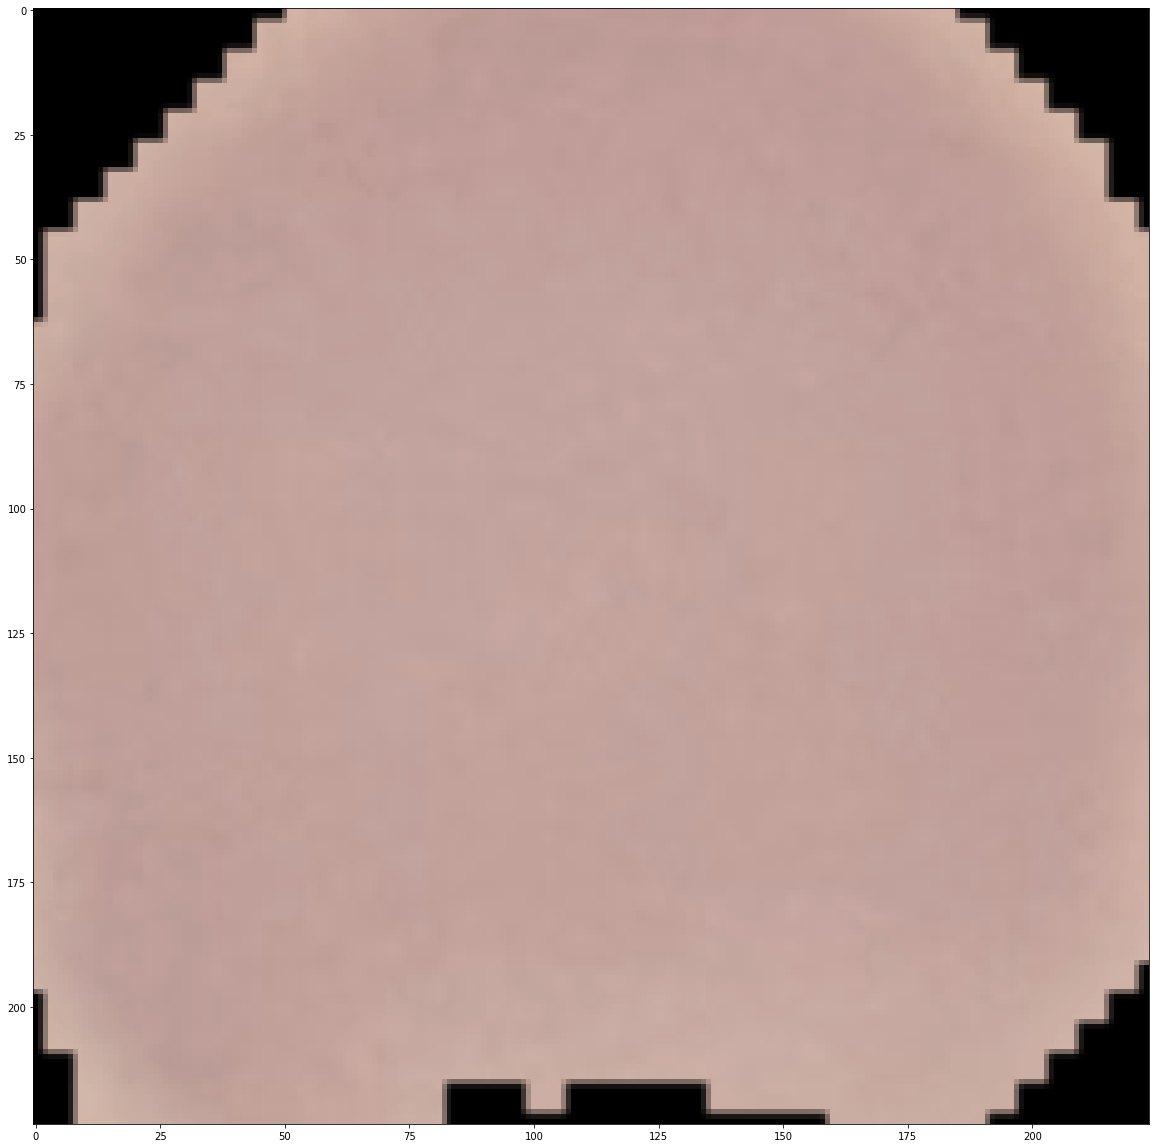

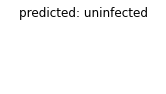

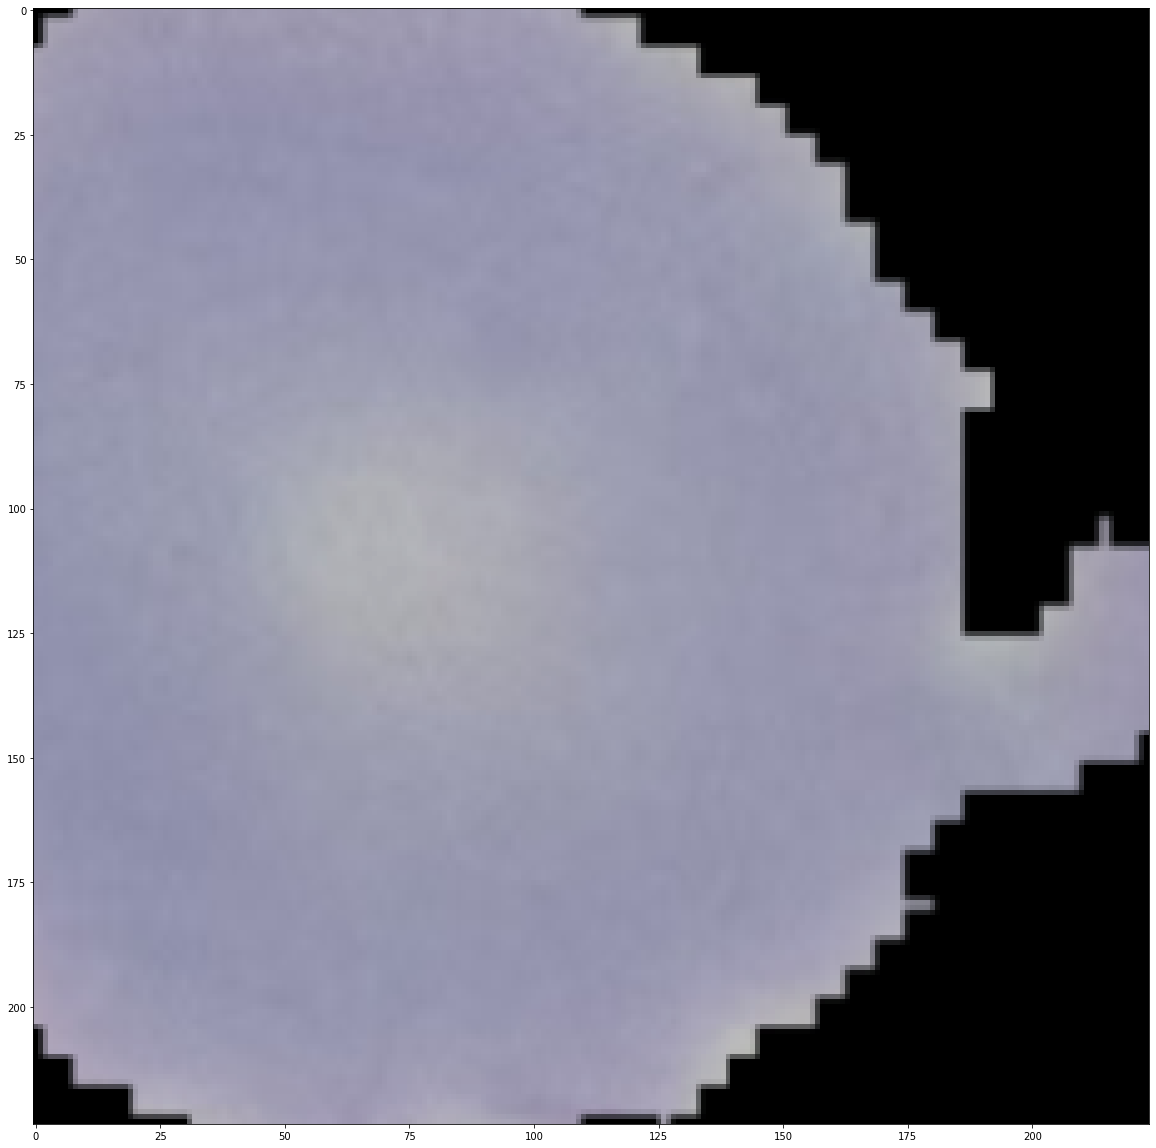

In [47]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
visualize_model(model_ft)

So Pytorch only gave me an accuracy of 90%, that's not bad considering I only had about 2-3 transformation parameters added to the transformation pipeline. 

### Tensorflow

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
# help(ImageDataGenerator)

In [25]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 20 degrees
                               width_shift_range=0.25, # Shift the pic width by a max of 5%
                               height_shift_range=0.25, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.15, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               vertical_flip=True, # Allow vertical flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [26]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [27]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [28]:
image_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 3)

In [29]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 2 classes: uninfected vs parasitic

In [30]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [32]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [33]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [34]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 100s 63ms/step - loss: 0.4956 - accuracy: 0.7427 - val_loss: 0.3425 - val_accuracy: 0.8723
Epoch 2/20
1560/1560 [==============================] - 96s 62ms/step - loss: 0.2683 - accuracy: 0.9021 - val_loss: 0.2731 - val_accuracy: 0.9000
Epoch 3/20
1560/1560 [==============================] - 95s 61ms/step - loss: 0.2618 - accuracy: 0.9093 - val_loss: 0.2462 - val_accuracy: 0.9112
Epoch 4/20
1560/1560 [==============================] - 96s 62ms/step - loss: 0.2511 - accuracy: 0.9121 - val_loss: 0.2464 - val_accuracy: 0.9096
Epoch 5/20
1560/1560 [==============================] - 96s 61ms/step - loss: 0.2457 - accuracy: 0.9171 - val_loss: 0.2592 - val_accuracy: 0.9085


In [35]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix

In [37]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

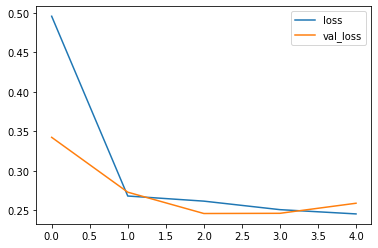

In [38]:
losses[['loss','val_loss']].plot()

In [39]:
model.metrics_names

['loss', 'accuracy']

In [40]:
model.evaluate_generator(test_image_gen)

[0.24803654849529266, 0.9126923084259033]

In [41]:
pred_probabilities = model.predict_generator(test_image_gen)

In [42]:
pred_probabilities

array([[8.5592819e-06],
       [1.3118719e-04],
       [1.2237759e-04],
       ...,
       [9.4598991e-01],
       [9.7156501e-01],
       [9.2609805e-01]], dtype=float32)

In [43]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
predictions = pred_probabilities > 0.5

In [45]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1300
           1       0.87      0.96      0.92      1300

    accuracy                           0.91      2600
   macro avg       0.92      0.91      0.91      2600
weighted avg       0.92      0.91      0.91      2600



In [46]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1117,  183],
       [  46, 1254]], dtype=int64)